In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import ast
import gensim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from nltk import word_tokenize
from gensim.models import Word2Vec
from category_encoders import WOEEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, validation_curve, KFold

from nlp_dauphine.preprocess_texts import (
    load_data,
    categorical_other,
)
from nlp_dauphine.embeddings import (
    vocabulary,
    print_neighbors,
    sentence_representations,
    co_occurence_matrix,
)
from nlp_dauphine.preprocess_time_series import compute_rolling
from nlp_dauphine.utils import set_working_dir, cosine, euclidean


In [3]:
set_working_dir()

Current working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine/notebooks
New working dir: c:/Users/Hugo/Documents/Travail/A5/Dauphine_challenge/nlp_dauphine


# Load Data

In [4]:
path = Path("data")
files_path = {
    "ecb": Path(path,"ecb_data_translate_cleaned.csv"),
    "fed": Path(path,"fed_data_translate_cleaned.csv"),
    "train_series": Path(path,"train_series_clean_no_0.csv"),
}

In [5]:
# LOAD TEXT DATA
df_ecb, df_fed, df_train_series = load_data(files_path)
print(df_ecb.shape, df_fed.shape, df_train_series.shape)

(1772, 6) (739, 6) (8240, 20)


In [6]:
df_train_series.list_speakers_ecb = df_train_series.list_speakers_ecb.apply(ast.literal_eval)
df_train_series.list_speakers_fed = df_train_series.list_speakers_fed.apply(ast.literal_eval)
df_train_series.id_ecb = df_train_series.id_ecb.apply(ast.literal_eval)
df_train_series.id_fed = df_train_series.id_fed.apply(ast.literal_eval)
df_train_series.list_languages_ecb = df_train_series.list_languages_ecb.apply(ast.literal_eval)

In [161]:
#https://neptune.ai/blog/data-augmentation-nlp

# Data Modelisation

## Train Test Split

In [7]:
# Train test split 
X=df_train_series.loc[:,df_train_series.columns!="Index + 1"]
y=np.sign(df_train_series[["Index + 1"]])

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=42)
print(X_train.shape,y_train.shape)

(6592, 19) (6592, 1)


# Categorical Encoding 

For the speakers WOEEncoder rather than One-hot encoding

In [8]:
col_speakers = ["speaker_"+str(i+1) for i in range(4)]

X_train = pd.concat([X_train, X_train['list_speakers_ecb'].apply(pd.Series)], axis=1)
X_train.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)

X_test = pd.concat([X_test, X_test['list_speakers_ecb'].apply(pd.Series)], axis=1)
X_test.rename({i:col for i, col in enumerate(col_speakers)},axis=1,inplace=True)

enc = WOEEncoder(cols=col_speakers)
X_train = enc.fit_transform(X_train, y_train)
X_test = enc.transform(X_test)

X_train.fillna(0,inplace=True)
X_test.fillna(0,inplace=True)

c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_dauph_env\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Hugo\anaconda3\envs\nlp_

for the index and the languages, one hot encoding 

In [9]:
X_train = pd.get_dummies(X_train, prefix ="",columns=["Index Name"], drop_first=False)
X_test = pd.get_dummies(X_test, prefix ="",columns=["Index Name"], drop_first=False)

In [10]:
df_lang_train = (
    pd.get_dummies(X_train.list_languages_ecb.apply(pd.Series).stack(), prefix="ecb")
    .groupby(level=0)
    .sum()
)
X_train = pd.concat([X_train, df_lang_train], axis=1)
df_lang_test = (
    pd.get_dummies(X_test.list_languages_ecb.apply(pd.Series).stack(), prefix="ecb")
    .groupby(level=0)
    .sum()
)
X_test = pd.concat([X_test, df_lang_test], axis=1)


In [11]:
cols_to_drop = [
    "id_ecb",
    "id_fed",
    "id_series",
    "list_speakers_fed",
    "list_speakers_ecb",
    "list_languages_ecb",
]
X_test.drop(cols_to_drop, axis=1, inplace=True)
X_train.drop(cols_to_drop, axis=1, inplace=True)


In [12]:
X_test.columns

Index(['Index - 9', 'Index - 8', 'Index - 7', 'Index - 6', 'Index - 5',
       'Index - 4', 'Index - 3', 'Index - 2', 'Index - 1', 'Index - 0',
       'text_concat_ecb', 'text_concat_fed', 'speaker_1', 'speaker_2',
       'speaker_3', 'speaker_4', '_CVIX Index', '_EURUSD Curncy',
       '_EURUSDV1M Curncy', '_MOVE Index', '_SPX Index', '_SRVIX Index',
       '_SX5E Index', '_V2X Index', '_VIX Index', 'ecb_de', 'ecb_en', 'ecb_es',
       'ecb_fr', 'ecb_it'],
      dtype='object')

# Text Embeddings

## Word Embeddings


### 1st Method: Vocabulary -> Co-Occurence Matrix -> SVD 

#### Vocabulary 

In [13]:
word2id_7500,word_counts_7500 = vocabulary(X_train.text_concat_ecb,7500)

#### Co-occurence Matrix

In [14]:
M5dist_ecb = co_occurence_matrix(X_train.text_concat_ecb, word2id_7500, window=5, distance_weighting=True)
M5dist_fed = co_occurence_matrix(X_train.text_concat_fed, word2id_7500, window=5, distance_weighting=True)

co-occurence matrix: 100%|██████████| 6592/6592 [02:17<00:00, 47.93it/s]


#### Scaling

In [15]:
scaler = StandardScaler()
M5dist_ecb = scaler.fit_transform(M5dist_ecb)
M5dist_fed = scaler.fit_transform(M5dist_fed)

#### SVD

In [16]:
svd = TruncatedSVD(n_components=200)
SVDEmbeddings_ecb = svd.fit_transform(M5dist_ecb)
SVDEmbeddings_fed = svd.fit_transform(M5dist_fed)
print(SVDEmbeddings_ecb.shape, SVDEmbeddings_fed.shape)

(7501, 200) (7501, 200)


In [17]:
svd.explained_variance_ratio_.sum()

0.6076534596260351

#### Analysis

In [107]:
print_neighbors(cosine, word2id_7500, SVDEmbeddings_ecb, 'financial')
print_neighbors(cosine, word2id_7500, SVDEmbeddings_fed, 'financial')

Plus proches voisins de financial selon la distance 'cosine': 
[['turmoil', 'instability', 'turbulence', 'contagion', 'market', 'vulnerability', 'assess', 'various', 'crisis']]
Plus proches voisins de financial selon la distance 'cosine': 
[['pose', 'crisis', 'function', 'system', 'strengthen', 'severe', 'intermediary', 'market', 'UNK']]


In [108]:
print_neighbors(euclidean, word2id_7500, SVDEmbeddings_ecb, 'financial')
print_neighbors(euclidean, word2id_7500, SVDEmbeddings_fed, 'financial')

Plus proches voisins de financial selon la distance 'euclidean': 
[['system', 'stability', 'crisis', 'sector', 'global', 'institution', 'also', 'market', 'economy']]
Plus proches voisins de financial selon la distance 'euclidean': 
[['crisis', 'system', 'stability', 'institution', 'firm', 'large', 'condition', 'global', 'risk']]


### 2nd Method: Vocabulary -> W2Vec

In [ ]:
word2id_7500, word_counts_7500 = vocabulary(X_train.text_concat_ecb,7500)

In [88]:
w2vec_fed = Word2Vec(vector_size=100,
                 window=5,
                 null_word=len(word_counts_7500))
w2vec_fed.build_vocab_from_freq(word_counts_7500)
w2vec_ecb = Word2Vec(vector_size=100,
                 window=5,
                 null_word=len(word_counts_7500))
w2vec_ecb.build_vocab_from_freq(word_counts_7500)

In [87]:
preprocessed_corpus_ecb = [
    word_tokenize(X_train.text_concat_ecb.values[i])
    for i in range(len(X_train.text_concat_ecb))
]

preprocessed_corpus_fed = [
    word_tokenize(X_train.text_concat_fed.values[i])
    for i in range(len(X_train.text_concat_fed))
]

In [89]:
w2vec_ecb.train(
    preprocessed_corpus_ecb,
    total_examples=len(X_train.text_concat_ecb),
    epochs=20,
    report_delay=1,
)


(213227259, 235516700)

In [93]:
w2vec_fed.train(
    preprocessed_corpus_fed,
    total_examples=len(X_train.text_concat_fed),
    epochs=20,
    report_delay=1,
)


(244000910, 271917220)

In [91]:
W2VEmbeddings_ecb = w2vec_ecb.wv.vectors
W2VEmbeddings_ecb.shape

(7501, 100)

In [95]:
W2VEmbeddings_fed = w2vec_fed.wv.vectors
W2VEmbeddings_fed.shape

(7501, 100)

### 3rd method: Pretrained Embedding on Finance Corpora

In [123]:
model_gn = gensim.models.KeyedVectors.load_word2vec_format('data/bankfinvec_100d_v1.txt')
model_gn = gensim.models.KeyedVectors.load_word2vec_format('data/custom_finvec_100d.txt')

In [145]:
vocab_size = 7501
emb_size = 100
embeddings_bankfin = np.zeros(shape=(vocab_size, emb_size))
words = []
count=0
for word, idx in word2id_7500.items():
    if word in model_gn.key_to_index:
        embeddings_bankfin[idx, :] = model_gn[word]
    else:
        count+=1
        words.append(word)
        embeddings_bankfin[idx, :] = np.zeros(emb_size)
count, words

(3677,
 ['ecb',
  'european',
  'europe',
  'eu',
  'eurosystem',
  'programme',
  'gdp',
  'emerge',
  'emu',
  'macroprudential',
  'globalisation',
  'remark',
  'stance',
  'germany',
  'implication',
  'september',
  'treaty',
  'sepa',
  'june',
  'ssm',
  'imf',
  'october',
  'lady',
  'parliament',
  'behaviour',
  'debate',
  'ccps',
  'december',
  'policymakers',
  'esrb',
  'accord',
  'citizen',
  'reinforce',
  'german',
  'spain',
  'greece',
  'basel',
  'circumstance',
  'vulnerability',
  'china',
  'january',
  'premia',
  'ireland',
  'confirm',
  'fragmentation',
  'frankfurt',
  'resilient',
  'credibility',
  'july',
  'spillover',
  'stabilise',
  'speak',
  'iii',
  'accommodative',
  'securitisation',
  'stem',
  'november',
  'italy',
  'recognise',
  'phillips',
  'gradual',
  'persistent',
  'credible',
  'pleasure',
  'turbulence',
  'august',
  'gentlemen',
  'accountability',
  'pact',
  'headline',
  'organise',
  'harmonise',
  'tommaso',
  'prevail',

I'm pretty sure it is going to be super bad because half of the words are not in this dictionary

In [140]:
embeddings_bankfin.shape

(7501, 100)

## Document Representation

AVERAGING MODEL

In [18]:
txt_ecb = X_train.text_concat_ecb
txt_fed = X_train.text_concat_fed
txt_ecb_val = X_test.text_concat_ecb
txt_fed_val = X_test.text_concat_fed

In [19]:
train_rep_ecb_svd = sentence_representations(txt_ecb, word2id_7500, SVDEmbeddings_ecb, np_func=np.mean)
train_rep_fed_svd = sentence_representations(txt_fed, word2id_7500, SVDEmbeddings_fed, np_func=np.mean)

100%|██████████| 6592/6592 [00:40<00:00, 162.24it/s]


In [20]:
val_rep_ecb_svd = sentence_representations(txt_ecb_val, word2id_7500, SVDEmbeddings_ecb, np_func=np.mean)
val_rep_fed_svd = sentence_representations(txt_fed_val, word2id_7500, SVDEmbeddings_fed, np_func=np.mean)

100%|██████████| 1648/1648 [00:09<00:00, 166.61it/s]


In [97]:
train_rep_ecb_w2v = sentence_representations(txt_ecb, word2id_7500, W2VEmbeddings_ecb, np_func=np.mean)
train_rep_fed_w2v = sentence_representations(txt_fed, word2id_7500, W2VEmbeddings_fed, np_func=np.mean)
val_rep_ecb_w2v = sentence_representations(txt_ecb_val, word2id_7500, W2VEmbeddings_ecb, np_func=np.mean)
val_rep_fed_w2v = sentence_representations(txt_fed_val, word2id_7500, W2VEmbeddings_fed, np_func=np.mean)

100%|██████████| 1648/1648 [00:10<00:00, 158.90it/s]


In [150]:
train_rep_ecb_fin = sentence_representations(txt_ecb, word2id_7500, embeddings_bankfin, np_func=np.mean)
train_rep_fed_fin = sentence_representations(txt_fed, word2id_7500, embeddings_bankfin, np_func=np.mean)
val_rep_ecb_fin = sentence_representations(txt_ecb_val, word2id_7500, embeddings_bankfin, np_func=np.mean)
val_rep_fed_fin = sentence_representations(txt_fed_val, word2id_7500, embeddings_bankfin, np_func=np.mean)

100%|██████████| 1648/1648 [00:12<00:00, 134.73it/s]


# Time Series Feature Engineering 

In [21]:
operations = ["std", "mean", "quantile_2", "quantile_8", "sum"]
nb_quantiles = [0.8, 0.2]
time_windows = [2, 5, 7]
params = []
for op in operations:
    for tw in time_windows:
        if "quantile" in op:
            for q in nb_quantiles:
                params.append(
                    {
                        "operation": op,
                        "time_window": tw,
                        "nb_quantile": q,
                    }
                )
        else:
            params.append(
                {
                    "operation": op,
                    "time_window": tw,
                }
            )

In [22]:
X_train_series = X_train.iloc[:,:10]
X_train_series = compute_rolling(X_train_series, params)

In [23]:
X_test_series = X_test.iloc[:,:10]
X_test_series = compute_rolling(X_test_series, params)

# Full Model 

In [24]:
X_train_concat = pd.concat(
    [
        X_train.iloc[:, 12:].reset_index(drop=True),# Speaker, Indices, languages
        X_train_series.reset_index(drop=True),# Time series FT
        pd.DataFrame(train_rep_ecb_svd), # Embeddings ecb
        pd.DataFrame(train_rep_fed_svd), # Embeddings fed
    ],
    axis=1,
    ignore_index=True,
)
X_train_concat

,0,1,2,3,4,5,6,7,8,9,...,433,434,435,436,437,438,439,440,441,442
0,0.666153,-0.495941,-0.04413,0.046529,1,0,0,0,0,0,...,-0.051169,-0.332617,-0.073112,-0.109234,-0.095451,-0.378600,-0.052429,0.154127,-0.382475,0.217477
1,0.000000,-0.495941,-0.04413,0.046529,0,0,0,0,0,1,...,-0.307564,0.060366,-0.028616,-0.209104,-0.238645,-0.209873,-0.428586,0.209545,-0.136479,-0.473047
2,0.000000,-0.495941,-0.04413,0.046529,0,0,0,0,0,0,...,0.028865,-0.004936,-0.089505,0.061598,0.110213,-0.534446,0.122170,-0.039494,0.045996,0.274344
3,0.498468,-0.495941,-0.04413,0.046529,0,0,0,0,0,0,...,0.038231,-0.008723,-0.058653,0.243944,-0.074080,-0.426647,0.014700,-0.210247,0.083744,-0.080634
4,-0.099496,-0.495941,-0.04413,0.046529,0,0,0,0,0,0,...,-0.184875,0.004226,-0.982662,1.304747,0.363660,0.019585,0.201448,-0.245593,-0.362040,-0.119258
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6587,0.763221,0.155216,-0.04413,0.046529,0,0,0,0,0,1,...,-0.492505,0.550472,0.309703,-0.021845,-0.217929,0.047857,-0.115480,-0.100315,-0.026545,-0.330325
6588,0.413505,-0.495941,-0.04413,0.046529,0,0,0,0,1,0,...,-0.307548,0.625444,-0.533657,-0.024489,-0.173686,0.280350,0.567488,-0.056665,0.090460,-0.401672
6589,0.551298,-0.495941,-0.04413,0.046529,0,0,0,0,0,0,...,0.156899,0.273635,0.012420,0.182757,0.005072,0.039562,-0.004094,-0.052776,0.042975,0.126148
6590,0.551298,-0.495941,-0.04413,0.046529,0,0,0,1,0,0,...,0.092320,-0.072711,-0.022418,0.172196,0.151882,0.210849,-0.160964,0.043706,0.270442,-0.464499


In [25]:
X_test_concat = pd.concat(
    [
        X_test.iloc[:, 12:].reset_index(drop=True),
        X_test_series.reset_index(drop=True),
        pd.DataFrame(val_rep_ecb_svd),
        pd.DataFrame(val_rep_fed_svd),
    ],
    axis=1,
    ignore_index=True,
)
X_test_concat

,0,1,2,3,4,5,6,7,8,9,...,433,434,435,436,437,438,439,440,441,442
0,0.000000,-0.495941,-0.04413,0.046529,0,1,0,0,0,0,...,-0.461317,0.107949,0.126440,0.374331,-0.429280,-0.199684,0.290203,0.455225,-0.468318,0.759363
1,0.413505,-0.495941,-0.04413,0.046529,0,0,1,0,0,0,...,0.334322,-0.163358,0.153032,0.183576,-0.381784,-0.209826,0.053130,-0.012324,-0.030406,0.017194
2,0.000000,-0.495941,-0.04413,0.046529,0,0,0,0,0,0,...,0.008231,0.045206,0.088512,-0.108455,0.054130,-0.026858,0.200866,-0.282440,-0.264459,0.055254
3,0.551298,-0.495941,-0.04413,0.046529,0,0,0,0,1,0,...,0.043747,0.090797,-0.243315,0.148388,0.186974,-0.025638,0.257589,0.042543,-0.030076,0.030422
4,0.666153,-0.495941,-0.04413,0.046529,0,0,0,0,0,1,...,0.312349,-0.173647,-0.066857,0.062608,-0.030562,0.060284,-0.183209,0.012364,0.219146,0.300608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1643,0.551298,-0.495941,-0.04413,0.046529,0,0,0,0,0,0,...,0.043747,0.090797,-0.243315,0.148388,0.186974,-0.025638,0.257589,0.042543,-0.030076,0.030422
1644,0.763221,0.983183,-0.04413,0.046529,0,0,0,0,0,0,...,-0.201479,-0.096034,0.094453,-0.009278,-0.064843,0.207038,-0.113531,-0.493210,0.260716,0.033517
1645,0.000000,-0.495941,-0.04413,0.046529,0,0,0,0,0,1,...,0.010192,-0.334377,0.280589,-0.118845,-0.362158,-0.329873,-0.008084,0.024302,-0.090418,0.107991
1646,0.666153,-0.495941,-0.04413,0.046529,0,0,0,0,1,0,...,0.312349,-0.173647,-0.066857,0.062608,-0.030562,0.060284,-0.183209,0.012364,0.219146,0.300608


In [26]:
X_train_concat.replace([np.inf, -np.inf], 0, inplace=True)
X_test_concat.replace([np.inf, -np.inf], 0, inplace=True)

In [98]:
X_train_concat2 = pd.concat(
    [
        X_train.iloc[:, 12:].reset_index(drop=True),# Speaker, Indices, languages
        X_train_series.reset_index(drop=True),# Time series FT
        pd.DataFrame(train_rep_ecb_w2v), # Embeddings ecb
        pd.DataFrame(train_rep_fed_w2v), # Embeddings fed
    ],
    axis=1,
    ignore_index=True,
)

X_test_concat2 = pd.concat(
    [
        X_test.iloc[:, 12:].reset_index(drop=True),
        X_test_series.reset_index(drop=True),
        pd.DataFrame(val_rep_ecb_w2v),
        pd.DataFrame(val_rep_fed_w2v),
    ],
    axis=1,
    ignore_index=True,
)
X_train_concat2.replace([np.inf, -np.inf], 0, inplace=True)
X_test_concat2.replace([np.inf, -np.inf], 0, inplace=True)
X_test_concat2.shape

(1648, 243)

In [151]:
X_train_concat3 = pd.concat(
    [
        X_train.iloc[:, 12:].reset_index(drop=True),# Speaker, Indices, languages
        X_train_series.reset_index(drop=True),# Time series FT
        pd.DataFrame(train_rep_ecb_fin), # Embeddings ecb
        pd.DataFrame(train_rep_fed_fin), # Embeddings fed
    ],
    axis=1,
    ignore_index=True,
)

X_test_concat3 = pd.concat(
    [
        X_test.iloc[:, 12:].reset_index(drop=True),
        X_test_series.reset_index(drop=True),
        pd.DataFrame(val_rep_ecb_fin),
        pd.DataFrame(val_rep_fed_fin),
    ],
    axis=1,
    ignore_index=True,
)
X_train_concat3.replace([np.inf, -np.inf], 0, inplace=True)
X_test_concat3.replace([np.inf, -np.inf], 0, inplace=True)
X_test_concat3.shape

(1648, 243)

## Logistic Regression

In [126]:
# Fit the classifier on the transformed training data and test it on the transformed validation data
clf = LogisticRegression(random_state=42,max_iter=20_000).fit(X_train_concat, np.array(y_train).ravel())
clf.score(X_train_concat, y_train)

0.6134708737864077

1st Method

In [127]:
clf.score(X_test_concat,y_test)

0.5242718446601942

2nd Method

In [99]:
# Fit the classifier on the transformed training data and test it on the transformed validation data
clf = LogisticRegression(random_state=42,max_iter=20_000).fit(X_train_concat2, np.array(y_train).ravel())
print(clf.score(X_train_concat2, y_train))
clf.score(X_test_concat2,y_test)

0.5854065533980582


0.5194174757281553

3rd Method

In [152]:
# Fit the classifier on the transformed training data and test it on the transformed validation data
clf = LogisticRegression(random_state=42,max_iter=20_000).fit(X_train_concat3, np.array(y_train).ravel())
print(clf.score(X_train_concat3, y_train))
clf.score(X_test_concat3,y_test)

0.5796419902912622


0.5121359223300971

## HistGradientBoosting

In [100]:
mask_categorical = [True if (x <=17) & (x>=4) else False for x in range(X_train_concat.shape[1])]

In [160]:
clf_boost = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=200,
    categorical_features=mask_categorical,
    random_state=42,
).fit(X_train_concat, np.array(y_train).ravel())
clf_boost.score(X_train_concat, y_train)


0.990746359223301

In [161]:
clf_boost.score(X_test_concat,y_test)

0.5782766990291263

2nd Method

In [102]:
mask_categorical = [True if (x <=17) & (x>=4) else False for x in range(X_train_concat2.shape[1])]

In [103]:
clf_boost2 = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=200,
    categorical_features=mask_categorical,
    random_state=42,
).fit(X_train_concat2, np.array(y_train).ravel())
print(clf_boost2.score(X_train_concat2, y_train))
clf_boost2.score(X_test_concat2,y_test)

0.9925667475728155


0.5819174757281553

3rd Method

In [153]:
mask_categorical = [True if (x <=17) & (x>=4) else False for x in range(X_train_concat3.shape[1])]
clf_boost3 = HistGradientBoostingClassifier(
    learning_rate=0.1,
    max_iter=200,
    categorical_features=mask_categorical,
    random_state=42,
).fit(X_train_concat3, np.array(y_train).ravel())
print(clf_boost3.score(X_train_concat3, y_train))
clf_boost3.score(X_test_concat3,y_test)

0.9896844660194175


0.5904126213592233

## Random Forest

In [78]:
rf = RandomForestClassifier()
rf.fit(X_train_concat, np.array(y_train).ravel())
rf.score(X_train_concat, y_train)

1.0

In [70]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [79]:
rf.score(X_test_concat,y_test)

0.5691747572815534

<Axes: >

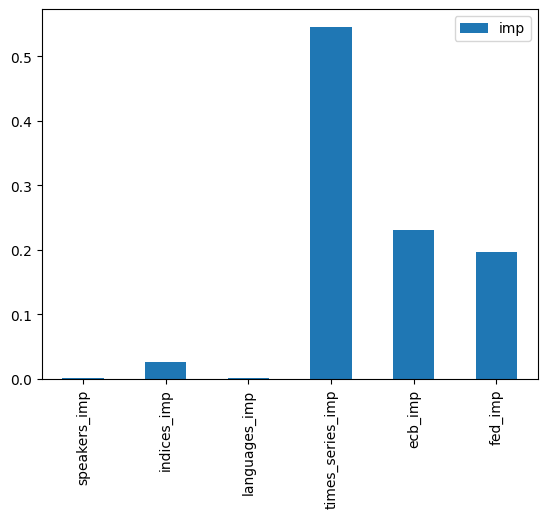

In [108]:
importances = rf.feature_importances_
imp_dict = {"speakers_imp" : np.sum(importances[:4]),
"indices_imp" : np.sum(importances[4:13]),
"languages_imp" : np.sum(importances[13:18]),
"times_series_imp" : np.sum(importances[18:43]),
"ecb_imp" : np.sum(importances[43:243]),
"fed_imp" : np.sum(importances[243:])}
pd.DataFrame.from_dict(imp_dict,orient="index").rename({0:"imp"},axis=1).plot(kind="bar")

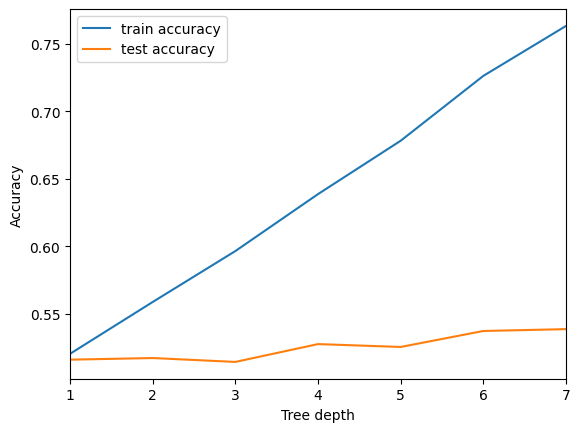

In [77]:
cv = KFold(shuffle=True, n_splits=5, random_state=42)
max_depth = [1, 2, 3, 4, 5, 6, 7]
    
train_scores, test_scores = validation_curve(
    rf, X_train_concat, np.array(y_train).ravel(), param_name="max_depth",
    param_range=max_depth, cv=cv,
    scoring="accuracy"
)
plt.plot(max_depth, train_scores.mean(axis=1), label="train accuracy")
plt.plot(max_depth, test_scores.mean(axis=1), label="test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.xlim([1, max(max_depth)])
plt.legend(loc="best")

2nd Method

In [104]:
rf2 = RandomForestClassifier()
rf2.fit(X_train_concat2, np.array(y_train).ravel())
rf2.score(X_train_concat2, y_train)

1.0

In [105]:
rf2.score(X_test_concat2,y_test)

0.5831310679611651

<Axes: >

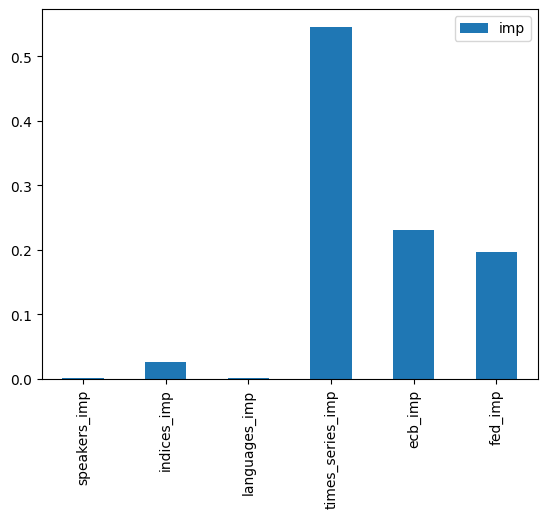

In [110]:
importances = rf2.feature_importances_
imp_dict2 = {"speakers_imp" : np.sum(importances[:4]),
"indices_imp" : np.sum(importances[4:13]),
"languages_imp" : np.sum(importances[13:18]),
"times_series_imp" : np.sum(importances[18:43]),
"ecb_imp" : np.sum(importances[43:143]),
"fed_imp" : np.sum(importances[143:])}
pd.DataFrame.from_dict(imp_dict2,orient="index").rename({0:"imp"},axis=1).plot(kind="bar")

In [111]:
imp_dict,imp_dict2

({'speakers_imp': 0.0016311520234973192,
  'indices_imp': 0.025073551971918583,
  'languages_imp': 0.0003671635558465756,
  'times_series_imp': 0.5460299066562152,
  'ecb_imp': 0.23030788624751675,
  'fed_imp': 0.19659033954500563},
 {'speakers_imp': 0.0035182315552587384,
  'indices_imp': 0.020459320282400894,
  'languages_imp': 0.0008899182383777172,
  'times_series_imp': 0.5227314668012208,
  'ecb_imp': 0.24243790759786316,
  'fed_imp': 0.2099631555248787})

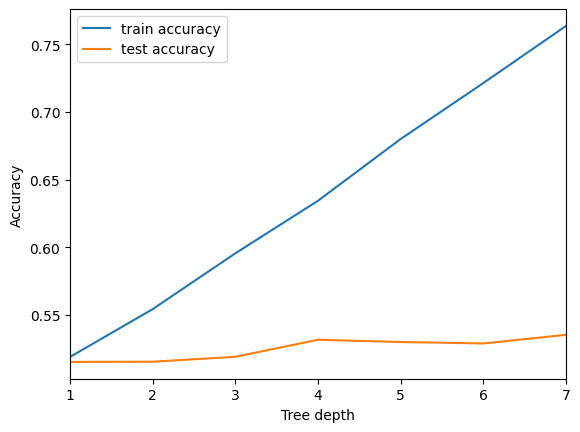

In [107]:
cv = KFold(shuffle=True, n_splits=5, random_state=42)
max_depth = [1, 2, 3, 4, 5, 6, 7]
    
train_scores, test_scores = validation_curve(
    rf, X_train_concat, np.array(y_train).ravel(), param_name="max_depth",
    param_range=max_depth, cv=cv,
    scoring="accuracy"
)
plt.plot(max_depth, train_scores.mean(axis=1), label="train accuracy")
plt.plot(max_depth, test_scores.mean(axis=1), label="test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.xlim([1, max(max_depth)])
plt.legend(loc="best")

3rd Method

In [154]:
rf3 = RandomForestClassifier()
rf3.fit(X_train_concat3, np.array(y_train).ravel())
rf3.score(X_train_concat3, y_train)

1.0

In [155]:
rf3.score(X_test_concat3,y_test)

0.5764563106796117

<Axes: >

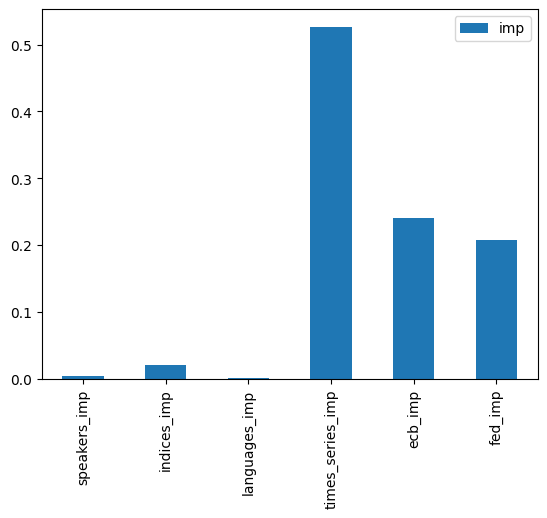

In [157]:
importances = rf3.feature_importances_
imp_dict3 = {"speakers_imp" : np.sum(importances[:4]),
"indices_imp" : np.sum(importances[4:13]),
"languages_imp" : np.sum(importances[13:18]),
"times_series_imp" : np.sum(importances[18:43]),
"ecb_imp" : np.sum(importances[43:143]),
"fed_imp" : np.sum(importances[143:])}
pd.DataFrame.from_dict(imp_dict3,orient="index").rename({0:"imp"},axis=1).plot(kind="bar")

In [158]:
imp_dict,imp_dict2, imp_dict3

({'speakers_imp': 0.0016311520234973192,
  'indices_imp': 0.025073551971918583,
  'languages_imp': 0.0003671635558465756,
  'times_series_imp': 0.5460299066562152,
  'ecb_imp': 0.23030788624751675,
  'fed_imp': 0.19659033954500563},
 {'speakers_imp': 0.0035182315552587384,
  'indices_imp': 0.020459320282400894,
  'languages_imp': 0.0008899182383777172,
  'times_series_imp': 0.5227314668012208,
  'ecb_imp': 0.24243790759786316,
  'fed_imp': 0.2099631555248787},
 {'speakers_imp': 0.0034525348678788566,
  'indices_imp': 0.020828983677737417,
  'languages_imp': 0.0007975899064786798,
  'times_series_imp': 0.5268250386184765,
  'ecb_imp': 0.24030538650466401,
  'fed_imp': 0.20779046642476473})

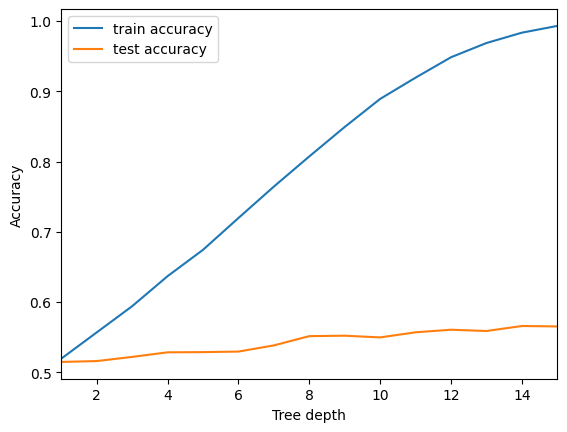

In [160]:
cv = KFold(shuffle=True, n_splits=5, random_state=42)
max_depth = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
    
train_scores, test_scores = validation_curve(
    rf, X_train_concat, np.array(y_train).ravel(), param_name="max_depth",
    param_range=max_depth, cv=cv,
    scoring="accuracy"
)
plt.plot(max_depth, train_scores.mean(axis=1), label="train accuracy")
plt.plot(max_depth, test_scores.mean(axis=1), label="test accuracy")
plt.ylabel('Accuracy')
plt.xlabel('Tree depth')
plt.xlim([1, max(max_depth)])
plt.legend(loc="best")